In [1]:
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option('display.max_colwidth', None)
#import os
#import re
import matplotlib.pyplot as plt
#import pickle
from IPython.display import display, Markdown
import seaborn as sns
from math import floor
import ast
import json
import re
import numpy as np
from scipy.stats import gmean

from dbmsbenchmarker import parameter, inspector

#import dbmsbenchmarker
#import bexhoma
from bexhoma import evaluators

%matplotlib inline

In [2]:
path = r"C:\data\benchmarks"
#path = r"/home/perdelt/benchmarks"

In [3]:
def get_workload(code):
    with open(path+"/"+code+"/queries.config",'r') as inp:
        workload_properties = ast.literal_eval(inp.read())
        return workload_properties

def map_index_to_queryname(numQuery):
    global query_properties
    if numQuery[1:] in query_properties and 'config' in query_properties[numQuery[1:]] and 'title' in query_properties[numQuery[1:]]['config']:
        return query_properties[numQuery[1:]]['config']['title']
    else:
        return numQuery

def get_df_benchmarking(evaluate):
    global query_properties
    #evaluate = inspector.inspector(path)
    #evaluate.load_experiment(code=code, silent=True)
    query_properties = evaluate.get_experiment_query_properties()
    num_of_queries = 0
    df = evaluate.get_aggregated_query_statistics(type='latency', name='execution', query_aggregate='Mean')
    if not df is None:
        df = df.sort_index().T.round(2)
        df.index = df.index.map(map_index_to_queryname)
        #print(df)
        num_of_queries = len(df.index)
    #print("\n### Power@Size ((3600*SF)/(geo times))")
    df = evaluate.get_aggregated_experiment_statistics(type='timer', name='execution', query_aggregate='Median', total_aggregate='Geo')
    df = (df/1000.0).sort_index().astype('float')
    df['Power@Size [~Q/h]'] = float(parameter.defaultParameters['SF'])*3600./df
    #df.columns = ['Power@Size [~Q/h]']
    df_power = df.copy()
    #print(df.round(2))
    #print(parameter.defaultParameters['SF'])
    #print("\n### Geometric Mean of Medians of Timer Run [s]")
    df = evaluate.get_aggregated_experiment_statistics(type='timer', name='run', query_aggregate='Median', total_aggregate='Geo')
    df = (df/1000.0).sort_index()
    df.columns = ['Geo Times [s]']
    df_geo_mean_runtime = df.copy()
    #print(df.round(2))
    df = pd.concat([df_power, df_geo_mean_runtime], axis=1)
    #df_time = df.copy()
    df_merged_time = pd.DataFrame()
    for connection_nr, connection in evaluate.benchmarks.dbms.items():
        df_time = pd.DataFrame()
        c = connection.connectiondata
        connection_name = c['name']
        orig_name = c['orig_name']
        eva = evaluate.get_experiment_connection_properties(c['name'])
        df_time.index = [connection_name]
        #df_time['SF'] = int(SF)
        #print(c)
        #print(connection.name)
        #print(connection.connection)
        df_time['orig_name'] = orig_name
        df_time['connection_name'] = connection_name
        df_time['SF'] = float(c['parameter']['connection_parameter']['loading_parameters']['SF'])
        df_time['pods'] = int(c['parameter']['connection_parameter']['loading_parameters']['PODS_PARALLEL'])
        #df_time['threads'] = int(c['parameter']['connection_parameter']['loading_parameters']['MYSQL_LOADING_THREADS'])
        df_time['num_experiment'] = int(c['parameter']['numExperiment'])
        df_time['num_client'] = int(c['parameter']['client'])
        df_time['benchmark_start'] = eva['times']['total'][c['name']]['time_start']
        df_time['benchmark_end'] = eva['times']['total'][c['name']]['time_end']
        df_merged_time = pd.concat([df_merged_time, df_time])
    df_time = df_merged_time.sort_index()
    # aggregate per parallel pods per dbms - not valid for model=container?
    #benchmark_start = df_time.groupby(['orig_name', 'SF', 'num_experiment', 'num_client']).min('benchmark_start')
    #benchmark_end = df_time.groupby(['orig_name', 'SF', 'num_experiment', 'num_client']).max('benchmark_end')
    benchmark_start = df_time.groupby(['connection_name', 'SF', 'num_experiment', 'num_client']).min('benchmark_start')
    benchmark_end = df_time.groupby(['connection_name', 'SF', 'num_experiment', 'num_client']).max('benchmark_end')
    df_benchmark = pd.DataFrame(benchmark_end['benchmark_end'] - benchmark_start['benchmark_start'])
    df_benchmark.columns = ['time [s]']
    #benchmark_count = df_time.groupby(['orig_name', 'SF', 'num_experiment', 'num_client']).count()
    benchmark_count = df_time.groupby(['connection_name', 'SF', 'num_experiment', 'num_client']).count()
    df_benchmark['count'] = benchmark_count['benchmark_end']
    df_benchmark['SF2'] = df_benchmark.index.map(lambda x: x[1])
    df_benchmark['num_of_queries'] = num_of_queries
    df_benchmark['Throughput@Size'] = (num_of_queries*3600.*df_benchmark['count']/df_benchmark['time [s]']*df_benchmark['SF2']).round(2)
    #df_benchmark['Throughput@Size [~GB/h]'] = (22*3600.*df_benchmark['count']/df_benchmark['time [s]']*df_benchmark['SF']).round(2)
    index_names = list(df_benchmark.index.names)
    #print(index_names)
    index_names[0] = "DBMS"
    df_benchmark.rename_axis(index_names, inplace=True)
    df_benchmark = df_benchmark.reset_index(level=['SF', 'num_experiment', 'num_client'])
    #print(df_benchmark)
    #return df_benchmark
    #df.index = df.index.map(lambda x: str(x)[:-2])
    #print(evaluate.e.benchmarker.code, df.index.duplicated())
    df = pd.concat([df, df_benchmark], axis=1)
    df.drop('SF2', axis=1, inplace=True)
    df.rename(columns={'num_experiment': 'experiment_run'}, inplace=True)
    df.rename(columns={'num_client': 'client'}, inplace=True)
    #df = df.sort_values('orig_name')
    df['Power@Size [~Q/h]'] = df['SF']*3600./df['total_timer_execution']
    return df

def get_performance_single(evaluation):
    df = get_df_benchmarking(evaluation)
    #print(df)
    df = df.sort_values(['experiment_run', 'client'])
    return df

def get_performance(evaluation):
    df = get_df_benchmarking(evaluation)
    df = df.sort_values(['experiment_run', 'client'])
    result = df.groupby('client').agg({
        'Throughput@Size': 'sum',
        'time [s]': 'max',
        'num_of_queries': 'max',
        'SF': 'max',
        'count': 'sum',
        'Power@Size [~Q/h]': lambda x: gmean(x.dropna()), # 'prod',
        #'num_errors': 'sum',
        #'Latency Distribution.Average Latency (microseconds)': 'mean'
    }).reset_index()
    result['Throughput@Size'] = (result['num_of_queries']*3600.*result['count']/result['time [s]']*result['SF']).round(2)
    return result

def get_performance_all(codes):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = inspector.inspector(path)
        evaluation.load_experiment(code=code, silent=True)
        #evaluation = evaluators.base(code=code, path=path)
        workload = get_workload(code)
        df = get_performance(evaluation)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance

def get_performance_all_single(codes):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = inspector.inspector(path)
        evaluation.load_experiment(code=code, silent=True)
        #evaluation = evaluators.benchbase(code=code, path=path)
        workload = get_workload(code)
        df = get_performance_single(evaluation)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance

def get_loading_time_max(evaluation):
    with open(path+"/"+evaluation.code+"/connections.config",'r') as inf:
        connections = ast.literal_eval(inf.read())
        pretty_connections = json.dumps(connections, indent=2)
        #print(pretty_connections)
        connections_sorted = sorted(connections, key=lambda c: c['name'])
        result = dict()
        for c in connections_sorted:
            result[c['name']] = {
                'time_load': c['timeLoad'],
                'time_ingest': c['timeIngesting'],
                'time_check': c['timeIndex'],
                #'terminals': c['parameter']['connection_parameter']['loading_parameters']['BENCHBASE_TERMINALS'],
                #'target': c['parameter']['connection_parameter']['loading_parameters']['BENCHBASE_TARGET'],
                'pods': c['parameter']['parallelism'],
                'tenant': c['parameter']['TENANT'] if 'TENANT' in c['parameter'] else '',
                'client': c['parameter']['client'],
                'datadisk': c['hostsystem']['datadisk'],
            }
            #result[c['parameter']['connection_parameter']['loading_parameters']['BENCHBASE_TERMINALS']] = c['timeIngesting']
        df = pd.DataFrame(result).T
        return df#df['time_load'].max()

def get_loading_time_max_all(codes):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = evaluators.benchbase(code=code, path=path)
        workload = get_workload(code)
        df = get_loading_time_max(evaluation)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance

def show_summary_monitoring_table(evaluate, component):
    df_monitoring = list()
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_util_s', component=component)
    df = df.max().sort_index() - df.min().sort_index() # compute difference of counter
    #df = df.T.max().sort_index() - df.T.min().sort_index() # compute difference of counter
    df_cleaned = pd.DataFrame(df)
    df_cleaned.columns = ["CPU [CPUs]"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_util', component=component)
    df = df.max().sort_index()
    df_cleaned = pd.DataFrame(df)
    df_cleaned.columns = ["Max CPU"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_memory', component=component)/1024
    #df = evaluate.get_loading_metrics('total_cpu_memory')/1024
    df = df.max().sort_index()
    df_cleaned = pd.DataFrame(df).round(2)
    df_cleaned.columns = ["Max RAM [Gb]"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_memory_cached', component=component)/1024
    #df = evaluate.get_loading_metrics('total_cpu_memory_cached')/1024
    df = df.max().sort_index()
    df_cleaned = pd.DataFrame(df)
    df_cleaned.columns = ["Max RAM Cached [Gb]"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    return df_monitoring

def get_monitoring_stream_single(evaluation):
    df_monitoring = show_summary_monitoring_table(evaluation, "stream")
    if len(df_monitoring) > 0:
        #print("\n### Stream SUT")
        df = pd.concat(df_monitoring, axis=1).round(2)
        df = df.reindex(index=evaluators.natural_sort(df.index))
        # If your DataFrame is named df and the index is a string like 'PostgreSQL-1-1-1024-0-1'
        df = df.copy()  # avoid modifying original
        df['client'] = df.index.str.rsplit('-', n=1).str[-1]
        #print(df)
        return df

def get_monitoring_stream(evaluation):
    df_monitoring = show_summary_monitoring_table(evaluation, "stream")
    if len(df_monitoring) > 0:
        #print("\n### Stream SUT")
        df = pd.concat(df_monitoring, axis=1).round(2)
        df = df.reindex(index=evaluators.natural_sort(df.index))
        # If your DataFrame is named df and the index is a string like 'PostgreSQL-1-1-1024-0-1'
        df = df.copy()  # avoid modifying original
        df['client'] = df.index.str.rsplit('-', n=1).str[-1]
        #print(df)
        result = df.groupby('client').agg({
            'CPU [CPUs]': 'sum',
            'Max RAM [Gb]': 'sum',
            'Max RAM Cached [Gb]': 'sum',
            'Max CPU': 'sum',
        }).reset_index()
        return result

def get_monitoring_stream_all(codes):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = evaluators.benchbase(code=code, path=path)
        workload = get_workload(code)
        df = get_monitoring_stream(evaluation)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance


In [4]:
def sanitize_filename(title, max_length=100):
    # Replace non-alphanumeric characters with underscores
    safe = re.sub(r'[^a-zA-Z0-9-_]+', '_', title.strip())
    # Truncate to a safe length
    return safe[:max_length].rstrip('_')
    
def plot_bars(df, y, title, estimator):
    df_plot = df.copy()
    #df_plot = df_plot[df_plot['client']=='1']
    df_plot = df_plot.sort_values(['num_tenants','type'])
    # Hatch styles for each type
    hatch_map = {
        'container': '/',
        'database': '\\',
        'schema': 'x'
    }
    hue_order = ['container', 'database', 'schema']
    # Create the plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        data=df_plot,
        x='num_tenants',
        y=y,
        hue='type',
        estimator=estimator,
        palette='Set2',
        hue_order=hue_order
    )
    """
    for bar in ax.patches:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # X: center of bar
                height,                             # Y: top of bar
                f'{height:.1f}',                    # Text (1 decimal place)
                ha='center', va='bottom', fontsize=8
            )
    """
    # Get tick positions (i.e., the x-axis categories)
    xticks = ax.get_xticks()
    bar_width = ax.patches[0].get_width()
    # Create a mapping from (num_tenants, type) to hatch
    grouped = df_plot.groupby(['num_tenants', 'type']).agg({y: estimator}).reset_index()
    #print(grouped)
    grouped_dict = {(row['num_tenants'], row['type']): hatch_map[row['type']] for _, row in grouped.iterrows()}
    bars = sorted(ax.patches, key=lambda bar: bar.get_x() if bar.get_height() > 0 else 10000)
    for bar, (_, row) in zip(bars, grouped.iterrows()):
        bar.my_id = (row['num_tenants'], row['type'])  # or anything else like an index or uuid
        bar.set_hatch(hatch_map[row['type']]) #grouped_dict[(bar.my_id)])
        bar.set_edgecolor('black')
        bar.set_linewidth(1)
    handles, labels = ax.get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        hatch = hatch_map.get(label, '')
        handle.set_hatch(hatch)
    # Final touches
    plt.legend(title='Type')
    ax.legend(fontsize=18)
    #ax.legend(fontsize=18, loc='upper left', bbox_to_anchor=(1, 1))  # move outside
    plt.title(f"{title}", fontsize=24)
    #plt.title(f"{title} by Number of Tenants and Type", fontsize=24)
    plt.xlabel("Number of Tenants", fontsize=18)
    ax.tick_params(axis='both', labelsize=16)
    # Remove y-axis label
    ax.set_ylabel('')  # or ax.set(ylabel='')
    plt.tight_layout()
    filename = "tpch_" + sanitize_filename(title) + ".png"    
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()



# Container

In [5]:
codes = [
    # container
    '1750860691', #tenants=1
    '1750862759', #tenants=2
    '1750865137', #tenants=3
    '1750867875', #tenants=4
    '1750870795', #tenants=5
    '1750874081', #tenants 6
    '1750877615', #tenants=7
    '1750881535', #tenants=8
    '1750885773', #tenants=9
    '1750890605', #tenants=10
    
    # database
    '1750860068', #tenants=1
    '1750862031', #tenants=2
    '1750864344', #tenants=3
    '1750866970', #tenants=4
    '1750869887', #tenants=5
    '1750873072', #tenants=6
    '1750876552', #tenants=7
    '1750880303', #tenants=8
    '1750884409', #tenants=9
    '1750889051', #tenants=10
    
    #schema
    '1750859440', #tenants=1
    '1750861312', #tenants=2
    '1750863504', #tenants=3
    '1750866067', #tenants=4
    '1750868888', #tenants=5
    '1750871956', #tenants=6   
    '1750875370', #tenants=7
    '1750879076', #tenants=8
    '1750883132', #tenants=9
    '1750887555', #tenants=10
]

In [66]:
codes = ['1751049830', '1751042932', '1751036351', '1751030495', '1751024409', '1751018248', '1751119375', '1751111813', '1751104451', '1751126280', '1751134502', '1751142830', '1751150564', '1751178052']

codes

['1751049830',
 '1751042932',
 '1751036351',
 '1751030495',
 '1751024409',
 '1751018248',
 '1751119375',
 '1751111813',
 '1751104451',
 '1751126280',
 '1751134502',
 '1751142830',
 '1751150564',
 '1751178052']

In [67]:
df_performance = get_performance_all_single(codes)
df_performance

,total_timer_execution,Power@Size [~Q/h],Geo Times [s],SF,experiment_run,client,time [s],count,num_of_queries,Throughput@Size,type,num_tenants
DBMS,,,,,,,,,,,,
PostgreSQL-BHT-1-0-1-1,5.581958,6449.350079,5.581958,10.0,1,1,1931,1,22,410.15,container,2
PostgreSQL-BHT-1-1-1-1,5.725308,6287.871693,5.725308,10.0,1,1,1961,1,22,403.88,container,2
PostgreSQL-BHT-1-0-2-1,5.600174,6428.371549,5.600174,10.0,1,2,1928,1,22,410.79,container,2
PostgreSQL-BHT-1-1-2-1,5.662387,6357.742695,5.662387,10.0,1,2,1935,1,22,409.30,container,2
PostgreSQL-BHT-2-1-1,5.805220,6201.315561,5.805220,10.0,1,1,1980,1,22,400.00,database,2
PostgreSQL-BHT-2-1-2,5.859996,6143.349100,5.859996,10.0,1,1,1995,1,22,396.99,database,2
PostgreSQL-BHT-2-2-1,5.786509,6221.367407,5.786509,10.0,1,2,1967,1,22,402.64,database,2
PostgreSQL-BHT-2-2-2,5.816515,6189.273202,5.816515,10.0,1,2,1983,1,22,399.39,database,2
PostgreSQL-BHT-2-1-1,5.804136,6202.473081,5.804136,10.0,1,1,1999,1,22,396.20,schema,2


In [68]:
df_multi = df_performance.set_index(['num_tenants', 'type'])
df_multi

total_timer_execution  Power@Size [~Q/h]  \
num_tenants type                                                  
2           container               5.581958        6449.350079   
            container               5.725308        6287.871693   
            container               5.600174        6428.371549   
            container               5.662387        6357.742695   
            database                5.805220        6201.315561   
            database                5.859996        6143.349100   
            database                5.786509        6221.367407   
            database                5.816515        6189.273202   
            schema                  5.804136        6202.473081   
            schema                  5.799652        6207.269260   
            schema                  5.818923        6186.711568   
            schema                  5.805793        6200.703804   
1           container               5.578556        6453.282885   
            container               5.625816        6399.072262   
            database                5.782133        6226.076538   
            database                5.740931        6270.759668   
            schema                  5.737534        6274.472477   
            schema                  5.772405        6236.568739   
3           container               5.655383        6365.616890   
            container               5.720550        6293.101030   
            container               5.711477        6303.098122   
            container               5.714150        6300.150163   
            container               5.779226        6229.208072   
            container               5.740482        6271.250650   
            database                5.970156        6029.993124   
            database                5.978560        6021.517153   
            database                5.936703        6063.971833   
            database                5.996505        6003.496964   
            database                5.983089        6016.958911   
            database                5.921182        6079.867363   
            schema                  6.013472        5986.558134   
            schema                  5.925583        6075.351249   
            schema                  5.888271        6113.849372   
            schema                  5.985615        6014.419551   
            schema                  5.914182        6087.063468   
            schema                  5.883397        6118.913625   
4           schema                  6.053494        5946.978816   
            schema                  6.113377        5888.725380   
            schema                  6.112811        5889.271085   
            schema                  5.982893        6017.155482   
            schema                  6.098934        5902.670906   
            schema                  6.138508        5864.617099   
            schema                  6.140258        5862.946141   
            schema                  5.997907        6002.094211   
            database                6.050219        5950.197417   
            database                6.124632        5877.904394   
            database                6.059949        5940.643794   
            database                5.979603        6020.466403   
            database                6.018658        5981.400304   
            database                6.169476        5835.179214   
            database                6.079736        5921.310062   
            database                5.934530        6066.192444   
            container               5.903926        6097.637463   
            container               5.914453        6086.783960   
            container               5.859869        6143.482266   
            container               5.857280        6146.197263   
            container               5.920179        6080.897511   
            container               5.905815        6095.686917   
   

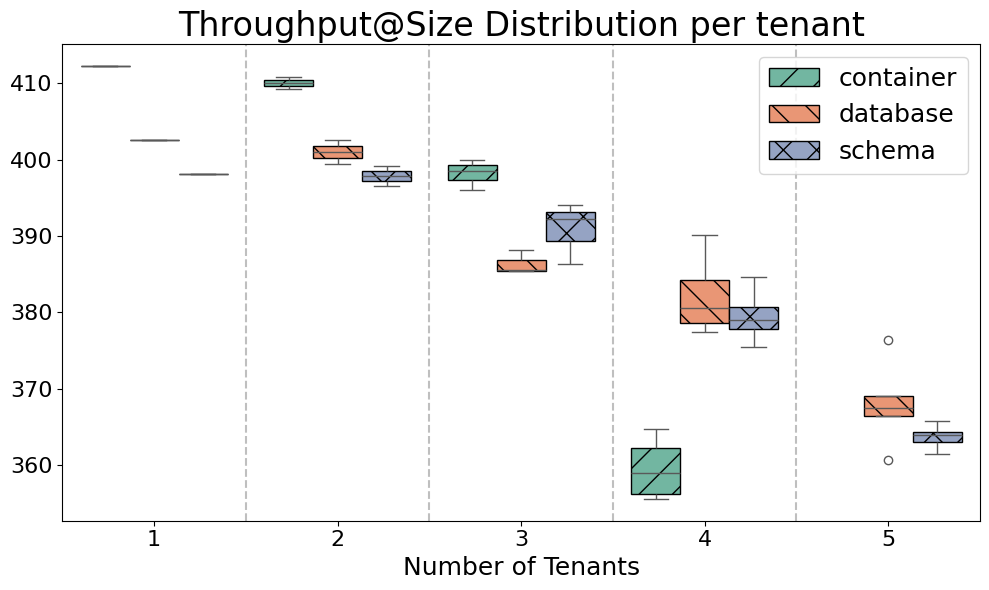

In [69]:
df = df_performance[df_performance['client']==2]
#df = df_performance.copy()
#print(df)
plt.figure(figsize=(10, 6))
# Hatch styles for each type
hatch_map = {
    'container': '/',
    'database': '\\',
    'schema': 'x'
}
hue_order = ['container', 'database', 'schema']

# Plot boxplots grouped by num_tenants and colored by type
ax = sns.boxplot(
    data=df,
    x='num_tenants',
    y='Throughput@Size',
    hue='type',
    palette='Set2'  # consistent colors per type
)

# Add vertical separator lines between groups
# Get the number of unique num_tenants and type
num_groups = df['num_tenants'].nunique()
num_types = df['type'].nunique()

# Extract hue order
hue_order = ax.get_legend_handles_labels()[1]
num_hue = len(hue_order)

# Get hue order from seaborn (types)
_, type_order = ax.get_legend_handles_labels()
num_types = len(type_order)

#print(len(ax.patches))
# Set hatches correctly: patches are grouped by x then by hue
for i, patch in enumerate(ax.patches):
    #print(i)
    type_index = i // (num_groups)
    if type_index >= num_types:
        break
    type_name = type_order[type_index]
    patch.set_hatch(hatch_map.get(type_name, ''))
    #print(hatch_map.get(type_name, ''))
    patch.set_edgecolor('black')
    patch.set_linewidth(1)

# Each num_tenants group has num_types boxes
for i in range(1, num_groups):
    xpos = i - 0.5 #0.5
    ax.axvline(x=xpos, color='gray', linestyle='--', alpha=0.5)


# Update legend with matching hatches
handles, labels = ax.get_legend_handles_labels()
for handle, label in zip(handles, labels):
    hatch = hatch_map.get(label, '')
    handle.set_hatch(hatch)
    handle.set_edgecolor('black')
    handle.set_linewidth(1)

title = "Throughput@Size Distribution per tenant"
plt.title(title, fontsize=24)
plt.xlabel("Number of Tenants")
plt.ylabel("")#"Goodput (requests/second)")
plt.xlabel("Number of Tenants", fontsize=18)
ax.tick_params(axis='both', labelsize=16)
plt.legend(title="Type")
ax.legend(fontsize=18)
plt.tight_layout()
filename = "tpch_" + sanitize_filename(title) + ".png"    
plt.savefig(filename, dpi=300, bbox_inches="tight")
plt.show()

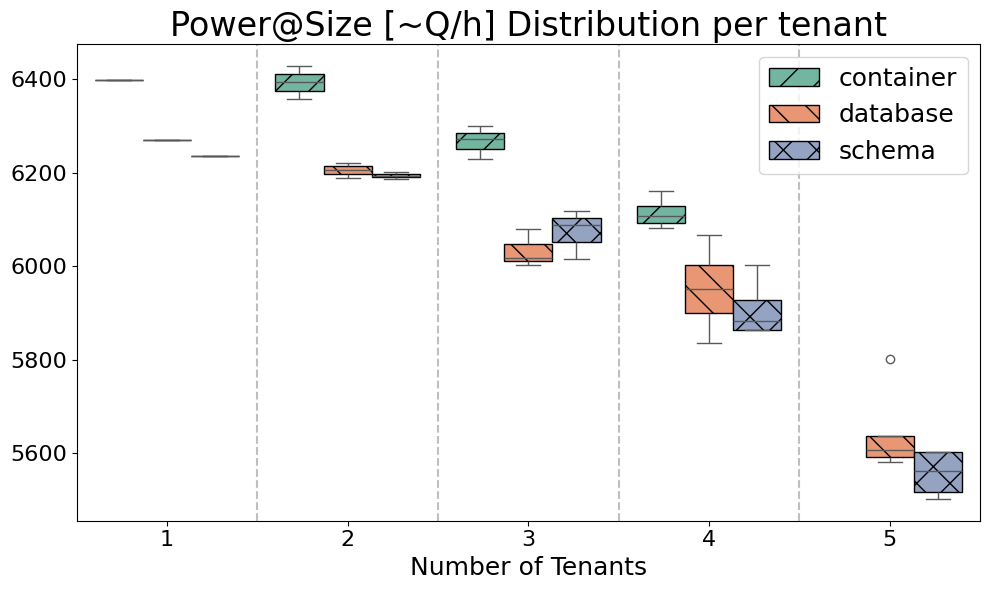

In [70]:
df = df_performance[df_performance['client']==2]
#df = df_performance.copy()
#print(df)
plt.figure(figsize=(10, 6))
# Hatch styles for each type
hatch_map = {
    'container': '/',
    'database': '\\',
    'schema': 'x'
}
hue_order = ['container', 'database', 'schema']

# Plot boxplots grouped by num_tenants and colored by type
ax = sns.boxplot(
    data=df,
    x='num_tenants',
    y='Power@Size [~Q/h]',
    hue='type',
    palette='Set2'  # consistent colors per type
)

# Add vertical separator lines between groups
# Get the number of unique num_tenants and type
num_groups = df['num_tenants'].nunique()
num_types = df['type'].nunique()

# Extract hue order
hue_order = ax.get_legend_handles_labels()[1]
num_hue = len(hue_order)

# Get hue order from seaborn (types)
_, type_order = ax.get_legend_handles_labels()
num_types = len(type_order)

#print(len(ax.patches))
# Set hatches correctly: patches are grouped by x then by hue
for i, patch in enumerate(ax.patches):
    #print(i)
    type_index = i // (num_groups)
    if type_index >= num_types:
        break
    type_name = type_order[type_index]
    patch.set_hatch(hatch_map.get(type_name, ''))
    #print(hatch_map.get(type_name, ''))
    patch.set_edgecolor('black')
    patch.set_linewidth(1)

# Each num_tenants group has num_types boxes
for i in range(1, num_groups):
    xpos = i - 0.5 #0.5
    ax.axvline(x=xpos, color='gray', linestyle='--', alpha=0.5)


# Update legend with matching hatches
handles, labels = ax.get_legend_handles_labels()
for handle, label in zip(handles, labels):
    hatch = hatch_map.get(label, '')
    handle.set_hatch(hatch)
    handle.set_edgecolor('black')
    handle.set_linewidth(1)

title = 'Power@Size [~Q/h] Distribution per tenant'
plt.title(title, fontsize=24)
plt.xlabel("Number of Tenants")
plt.ylabel("")#"Goodput (requests/second)")
plt.xlabel("Number of Tenants", fontsize=18)
ax.tick_params(axis='both', labelsize=16)
plt.legend(title="Type")
ax.legend(fontsize=18)
plt.tight_layout()
filename = "tpch_" + sanitize_filename(title) + ".png"    
plt.savefig(filename, dpi=300, bbox_inches="tight")
plt.show()

In [71]:
df_performance = get_performance_all(codes)
df_performance

,client,Throughput@Size,time [s],num_of_queries,SF,count,Power@Size [~Q/h],type,num_tenants
0,1,807.75,1961,22,10.0,2,6368.099072,container,2
1,2,818.60,1935,22,10.0,2,6392.959585,container,2
0,1,793.98,1995,22,10.0,2,6172.264282,database,2
1,2,798.79,1983,22,10.0,2,6205.299555,database,2
0,1,792.40,1999,22,10.0,2,6204.870707,schema,2
1,2,793.19,1997,22,10.0,2,6193.703735,schema,2
0,1,416.84,1900,22,10.0,1,6453.282885,container,1
1,2,412.29,1921,22,10.0,1,6399.072262,container,1
0,1,400.00,1980,22,10.0,1,6226.076538,database,1
1,2,402.64,1967,22,10.0,1,6270.759668,database,1


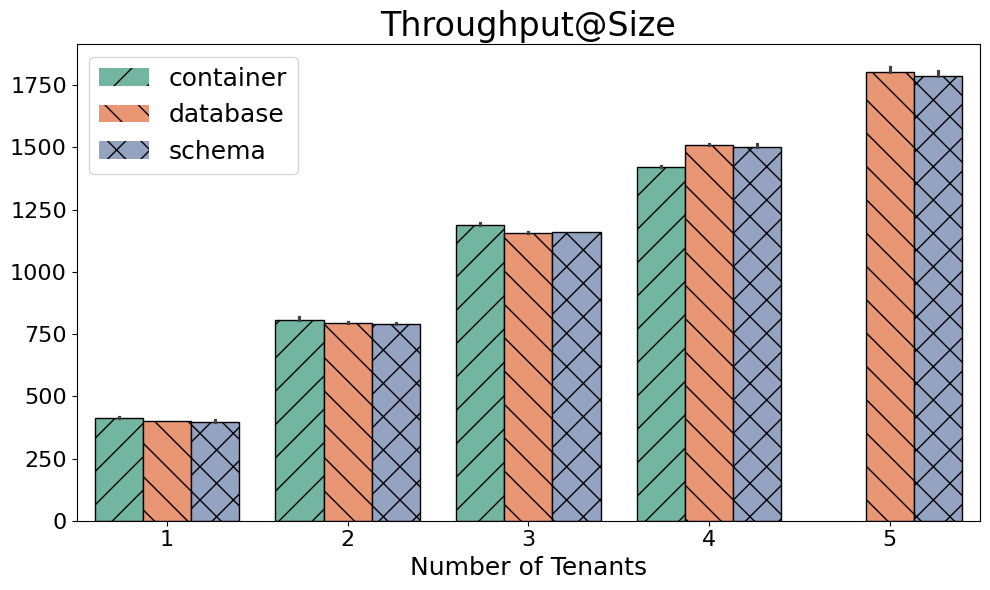

In [72]:
plot_bars(df_performance, y='Throughput@Size', title='Throughput@Size', estimator='min')

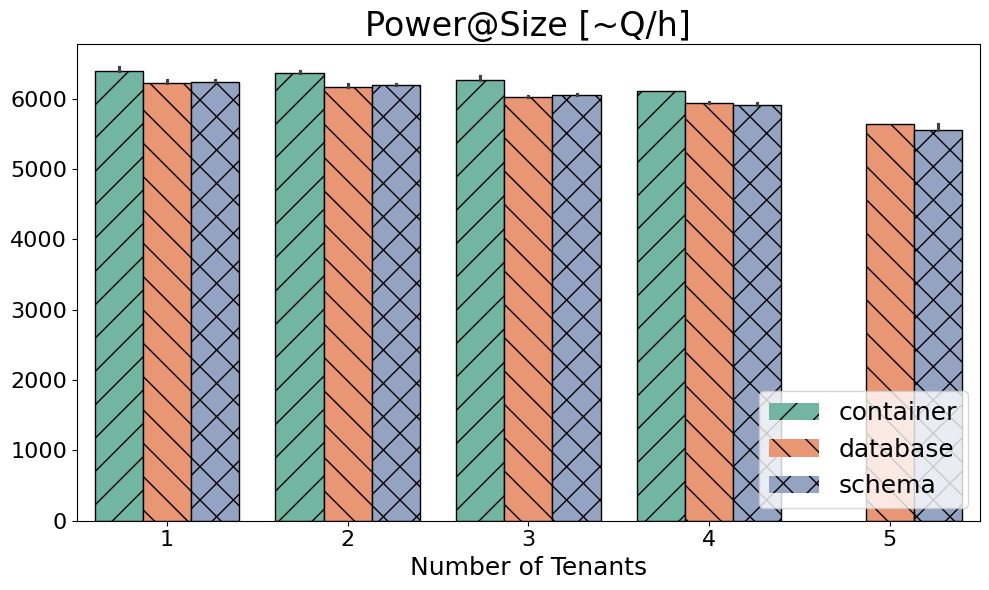

In [73]:
plot_bars(df_performance, y='Power@Size [~Q/h]', title='Power@Size [~Q/h]', estimator='min')

In [96]:
df_performance = get_loading_time_max_all(codes)
df_performance

,time_load,time_ingest,time_check,pods,tenant,client,datadisk,type,num_tenants
PostgreSQL-BHT-1-0-1-1,2436.0,875.0,1558.0,1,0,1,27211,container,2
PostgreSQL-BHT-1-0-2-1,2436.0,875.0,1558.0,1,0,2,27211,container,2
PostgreSQL-BHT-1-1-1-1,2419.0,871.0,1544.0,1,1,1,27211,container,2
PostgreSQL-BHT-1-1-2-1,2419.0,871.0,1544.0,1,1,2,27211,container,2
PostgreSQL-BHT-2-1-1,3616.0,1206.0,2172.0,2,,1,54413,database,2
PostgreSQL-BHT-2-1-2,3616.0,1206.0,2172.0,2,,1,54413,database,2
PostgreSQL-BHT-2-2-1,3616.0,1206.0,2172.0,2,,2,54413,database,2
PostgreSQL-BHT-2-2-2,3616.0,1206.0,2172.0,2,,2,54413,database,2
PostgreSQL-BHT-2-1-1,3103.0,1194.0,1905.0,2,,1,54383,schema,2
PostgreSQL-BHT-2-1-2,3103.0,1194.0,1905.0,2,,1,54383,schema,2


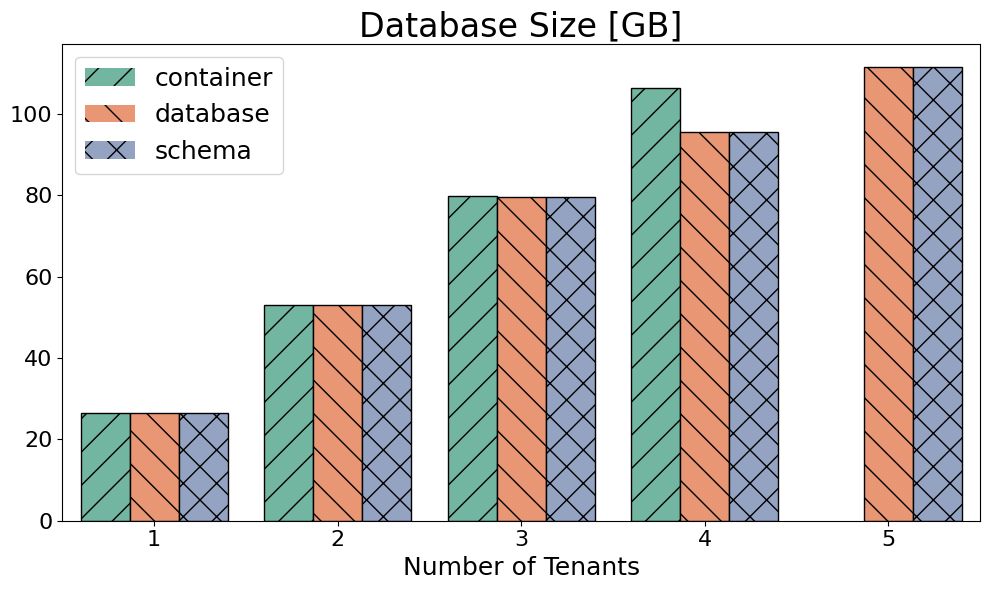

In [98]:
df_performance_first = df_performance[df_performance['client'] == '1']
# Divide datadisk by the count of rows with the same type and num_tenants
df = df_performance_first.copy()
# Create a mask for rows where type is not "container"
mask = df['type'] != 'container'

# Only apply the group count to the relevant rows
group_counts = df[mask].groupby(['type', 'num_tenants'])['datadisk'].transform('count')

# Initialize the column with NaN (or 0, if preferred)
df['datadisk_normalized'] = df['datadisk'] / 1024

# Apply the normalized value only where the mask is True
df.loc[mask, 'datadisk_normalized'] = df.loc[mask, 'datadisk'] / group_counts / 1024

plot_bars(df, y='datadisk_normalized', title='Database Size [GB]', estimator='sum')

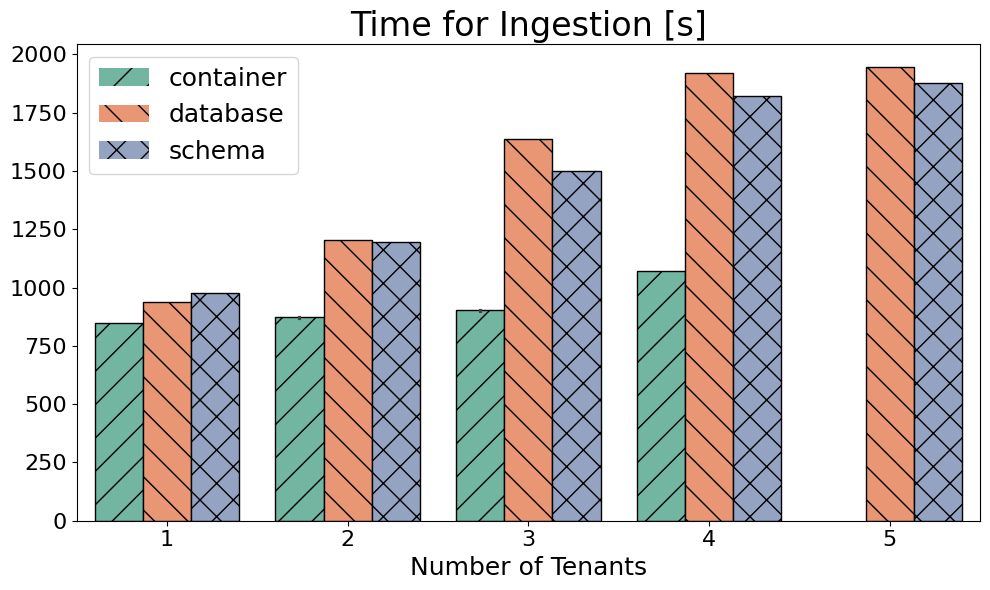

In [76]:
plot_bars(df_performance, y='time_ingest', title='Time for Ingestion [s]', estimator='max')

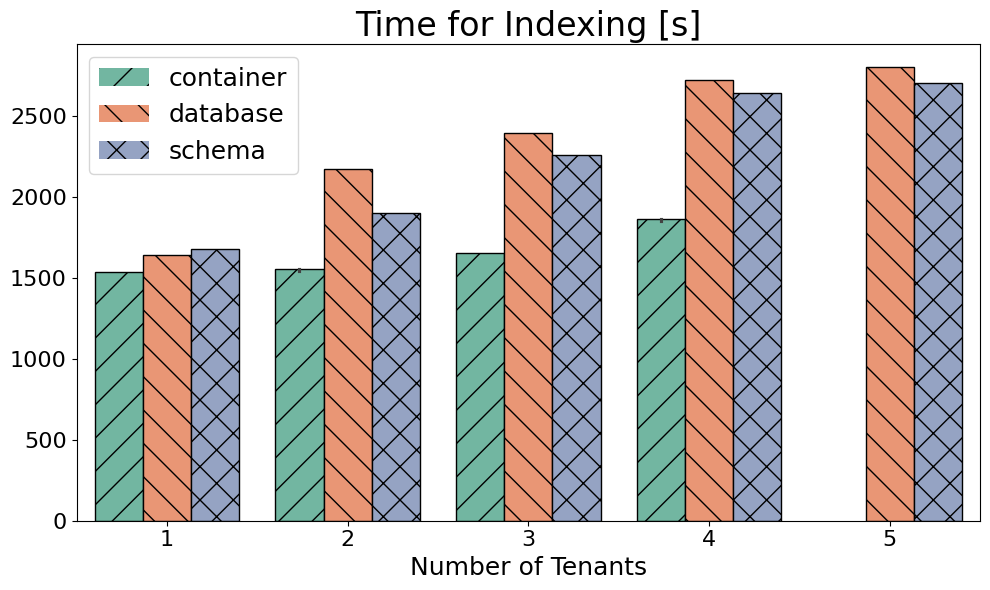

In [77]:
plot_bars(df_performance, y='time_check', title='Time for Indexing [s]', estimator='max')

In [78]:
df_performance = get_monitoring_stream_all(codes)
df_performance = df_performance[df_performance['client'] == '1']
df_performance

,client,CPU [CPUs],Max RAM [Gb],Max RAM Cached [Gb],Max CPU,type,num_tenants
0,1,21122.16,102.01,133.83,15.92,container,2
0,1,21627.18,73.43,104.86,14.84,database,2
0,1,21782.59,58.97,90.77,14.08,schema,2
0,1,10249.41,57.44,73.35,7.95,container,1
0,1,10597.67,57.45,73.36,7.98,database,1
0,1,10827.06,57.44,73.35,7.98,schema,1
0,1,32000.65,164.70,208.89,23.93,container,3
0,1,33336.32,127.23,174.93,21.61,database,3
0,1,33096.24,85.15,131.77,20.91,schema,3
0,1,44905.47,135.77,198.45,28.60,schema,4


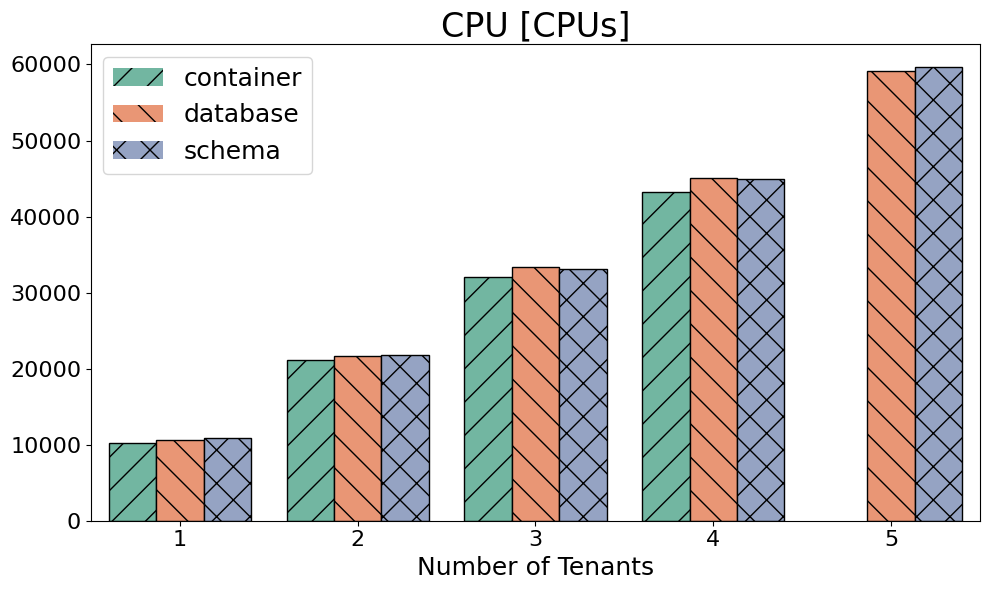

In [79]:
plot_bars(df_performance, y='CPU [CPUs]', title='CPU [CPUs]', estimator='max')

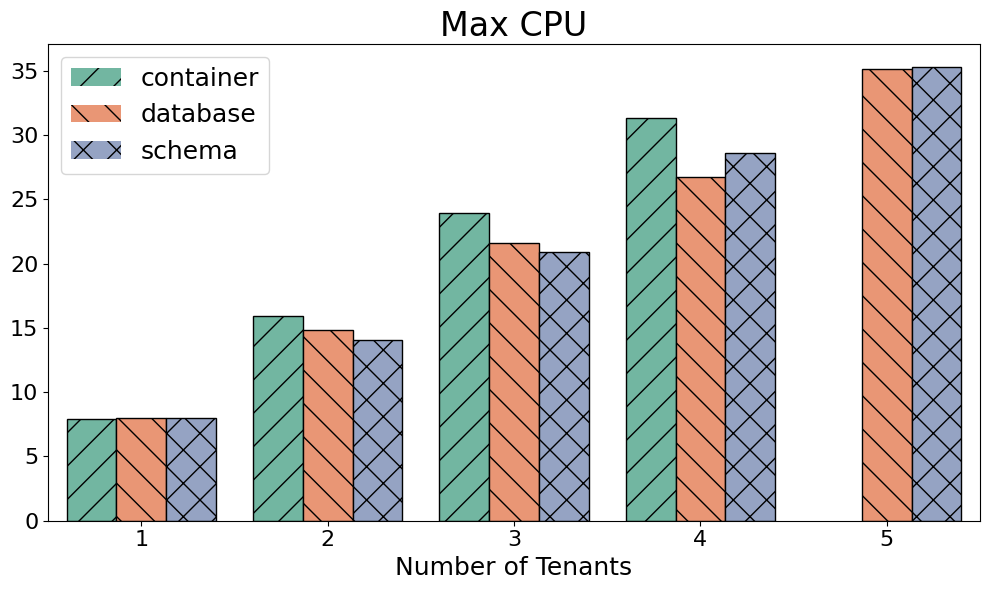

In [80]:
plot_bars(df_performance, y='Max CPU', title='Max CPU', estimator='sum')

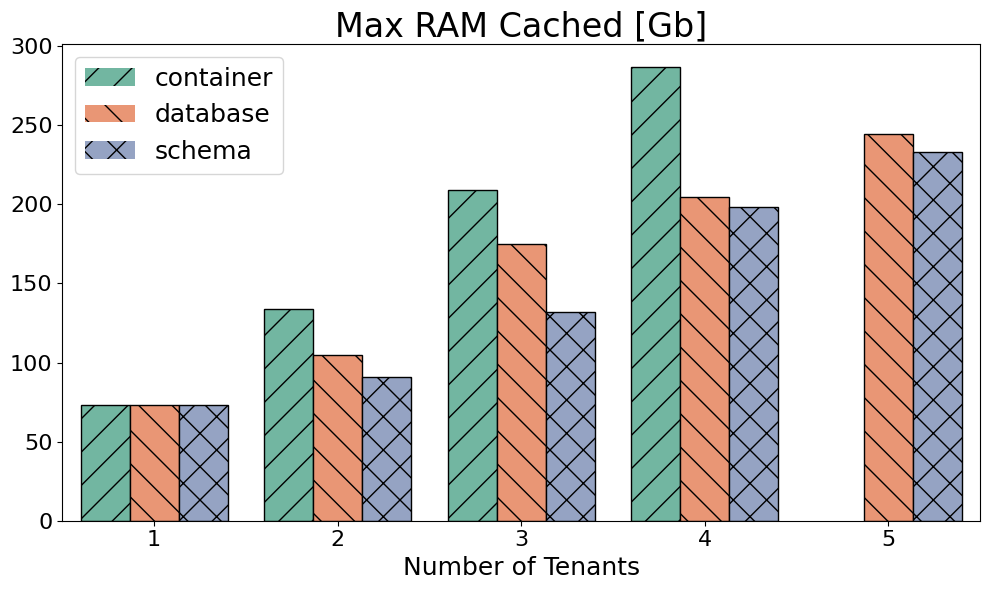

In [81]:
plot_bars(df_performance, y='Max RAM Cached [Gb]', title='Max RAM Cached [Gb]', estimator='sum')

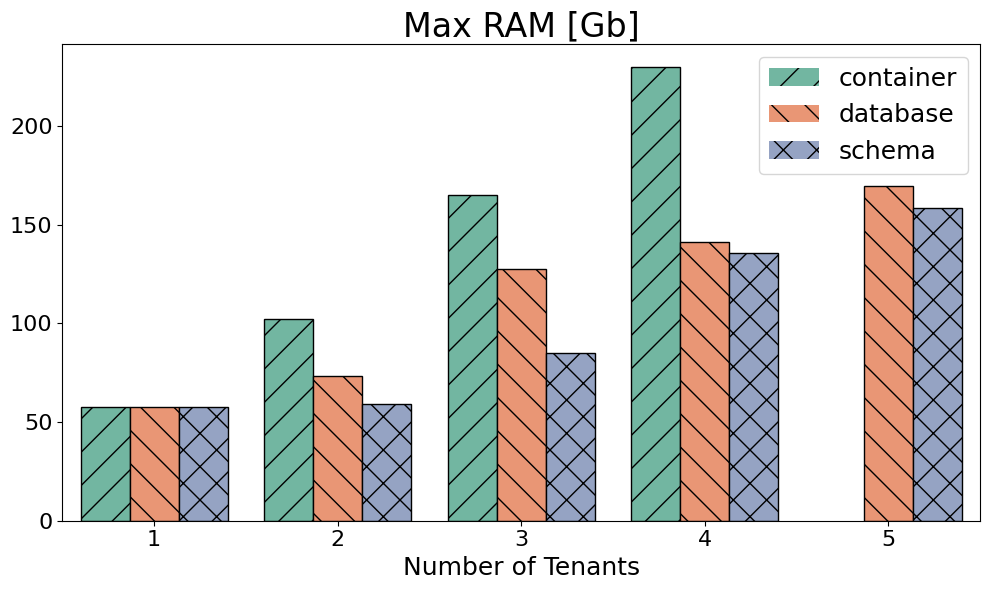

In [82]:
plot_bars(df_performance, y='Max RAM [Gb]', title='Max RAM [Gb]', estimator='sum')

# Efficiency

In [83]:
df_performance_monitoring = get_monitoring_stream_all(codes)
df_performance_monitoring["client"] = df_performance_monitoring["client"].astype(int)
#df_performance_monitoring = df_performance_monitoring[df_performance_monitoring['client'] == '1']
df_performance_monitoring

,client,CPU [CPUs],Max RAM [Gb],Max RAM Cached [Gb],Max CPU,type,num_tenants
0,1,21122.16,102.01,133.83,15.92,container,2
1,2,20536.07,116.66,148.48,15.94,container,2
0,1,21627.18,73.43,104.86,14.84,database,2
1,2,21213.02,73.99,105.29,15.30,database,2
0,1,21782.59,58.97,90.77,14.08,schema,2
1,2,21532.46,73.67,105.46,14.96,schema,2
0,1,10249.41,57.44,73.35,7.95,container,1
1,2,10563.69,58.33,74.24,7.96,container,1
0,1,10597.67,57.45,73.36,7.98,database,1
1,2,10686.47,58.34,74.26,7.96,database,1


In [84]:
df_performance = get_performance_all(codes)
df_performance["client"] = df_performance["client"].astype(int)
#df_performance = df_performance[df_performance['client'] == '2']
df_performance

,client,Throughput@Size,time [s],num_of_queries,SF,count,Power@Size [~Q/h],type,num_tenants
0,1,807.75,1961,22,10.0,2,6368.099072,container,2
1,2,818.60,1935,22,10.0,2,6392.959585,container,2
0,1,793.98,1995,22,10.0,2,6172.264282,database,2
1,2,798.79,1983,22,10.0,2,6205.299555,database,2
0,1,792.40,1999,22,10.0,2,6204.870707,schema,2
1,2,793.19,1997,22,10.0,2,6193.703735,schema,2
0,1,416.84,1900,22,10.0,1,6453.282885,container,1
1,2,412.29,1921,22,10.0,1,6399.072262,container,1
0,1,400.00,1980,22,10.0,1,6226.076538,database,1
1,2,402.64,1967,22,10.0,1,6270.759668,database,1


In [85]:
merged_df = pd.merge(df_performance, df_performance_monitoring, on=['type', 'num_tenants', 'client'], how='inner')
merged_df

,client,Throughput@Size,time [s],num_of_queries,SF,count,Power@Size [~Q/h],type,num_tenants,CPU [CPUs],Max RAM [Gb],Max RAM Cached [Gb],Max CPU
0,1,807.75,1961,22,10.0,2,6368.099072,container,2,21122.16,102.01,133.83,15.92
1,2,818.60,1935,22,10.0,2,6392.959585,container,2,20536.07,116.66,148.48,15.94
2,1,793.98,1995,22,10.0,2,6172.264282,database,2,21627.18,73.43,104.86,14.84
3,2,798.79,1983,22,10.0,2,6205.299555,database,2,21213.02,73.99,105.29,15.30
4,1,792.40,1999,22,10.0,2,6204.870707,schema,2,21782.59,58.97,90.77,14.08
5,2,793.19,1997,22,10.0,2,6193.703735,schema,2,21532.46,73.67,105.46,14.96
6,1,416.84,1900,22,10.0,1,6453.282885,container,1,10249.41,57.44,73.35,7.95
7,2,412.29,1921,22,10.0,1,6399.072262,container,1,10563.69,58.33,74.24,7.96
8,1,400.00,1980,22,10.0,1,6226.076538,database,1,10597.67,57.45,73.36,7.98
9,2,402.64,1967,22,10.0,1,6270.759668,database,1,10686.47,58.34,74.26,7.96


In [86]:
merged_df['CPUs/Throughput'] = merged_df['CPU [CPUs]'] / merged_df['Throughput@Size'] / 3600. * 1000.

merged_df

,client,Throughput@Size,time [s],num_of_queries,SF,count,Power@Size [~Q/h],type,num_tenants,CPU [CPUs],Max RAM [Gb],Max RAM Cached [Gb],Max CPU,CPUs/Throughput
0,1,807.75,1961,22,10.0,2,6368.099072,container,2,21122.16,102.01,133.83,15.92,7.263716
1,2,818.60,1935,22,10.0,2,6392.959585,container,2,20536.07,116.66,148.48,15.94,6.968561
2,1,793.98,1995,22,10.0,2,6172.264282,database,2,21627.18,73.43,104.86,14.84,7.566374
3,2,798.79,1983,22,10.0,2,6205.299555,database,2,21213.02,73.99,105.29,15.30,7.376789
4,1,792.40,1999,22,10.0,2,6204.870707,schema,2,21782.59,58.97,90.77,14.08,7.635941
5,2,793.19,1997,22,10.0,2,6193.703735,schema,2,21532.46,73.67,105.46,14.96,7.540739
6,1,416.84,1900,22,10.0,1,6453.282885,container,1,10249.41,57.44,73.35,7.95,6.830099
7,2,412.29,1921,22,10.0,1,6399.072262,container,1,10563.69,58.33,74.24,7.96,7.117219
8,1,400.00,1980,22,10.0,1,6226.076538,database,1,10597.67,57.45,73.36,7.98,7.359493
9,2,402.64,1967,22,10.0,1,6270.759668,database,1,10686.47,58.34,74.26,7.96,7.372501


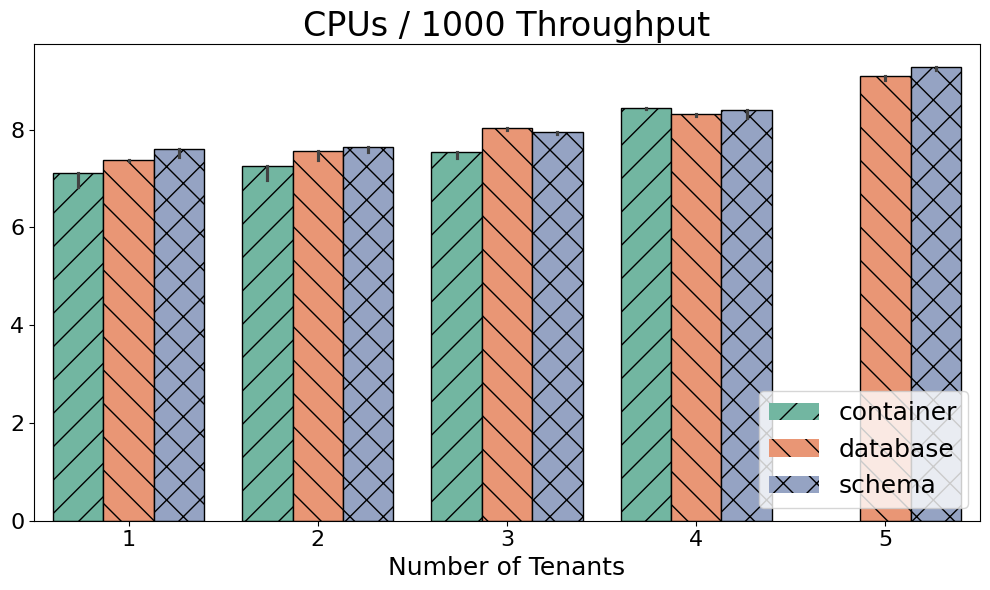

In [87]:
plot_bars(merged_df, y='CPUs/Throughput', title='CPUs / 1000 Throughput', estimator='max')

In [88]:
merged_df['RAM/Throughput'] = merged_df['Max RAM [Gb]'] / merged_df['Throughput@Size'] * 1000.

merged_df

,client,Throughput@Size,time [s],num_of_queries,SF,count,Power@Size [~Q/h],type,num_tenants,CPU [CPUs],Max RAM [Gb],Max RAM Cached [Gb],Max CPU,CPUs/Throughput,RAM/Throughput
0,1,807.75,1961,22,10.0,2,6368.099072,container,2,21122.16,102.01,133.83,15.92,7.263716,126.289075
1,2,818.60,1935,22,10.0,2,6392.959585,container,2,20536.07,116.66,148.48,15.94,6.968561,142.511605
2,1,793.98,1995,22,10.0,2,6172.264282,database,2,21627.18,73.43,104.86,14.84,7.566374,92.483438
3,2,798.79,1983,22,10.0,2,6205.299555,database,2,21213.02,73.99,105.29,15.30,7.376789,92.627599
4,1,792.40,1999,22,10.0,2,6204.870707,schema,2,21782.59,58.97,90.77,14.08,7.635941,74.419485
5,2,793.19,1997,22,10.0,2,6193.703735,schema,2,21532.46,73.67,105.46,14.96,7.540739,92.878125
6,1,416.84,1900,22,10.0,1,6453.282885,container,1,10249.41,57.44,73.35,7.95,6.830099,137.798676
7,2,412.29,1921,22,10.0,1,6399.072262,container,1,10563.69,58.33,74.24,7.96,7.117219,141.478086
8,1,400.00,1980,22,10.0,1,6226.076538,database,1,10597.67,57.45,73.36,7.98,7.359493,143.625000
9,2,402.64,1967,22,10.0,1,6270.759668,database,1,10686.47,58.34,74.26,7.96,7.372501,144.893702


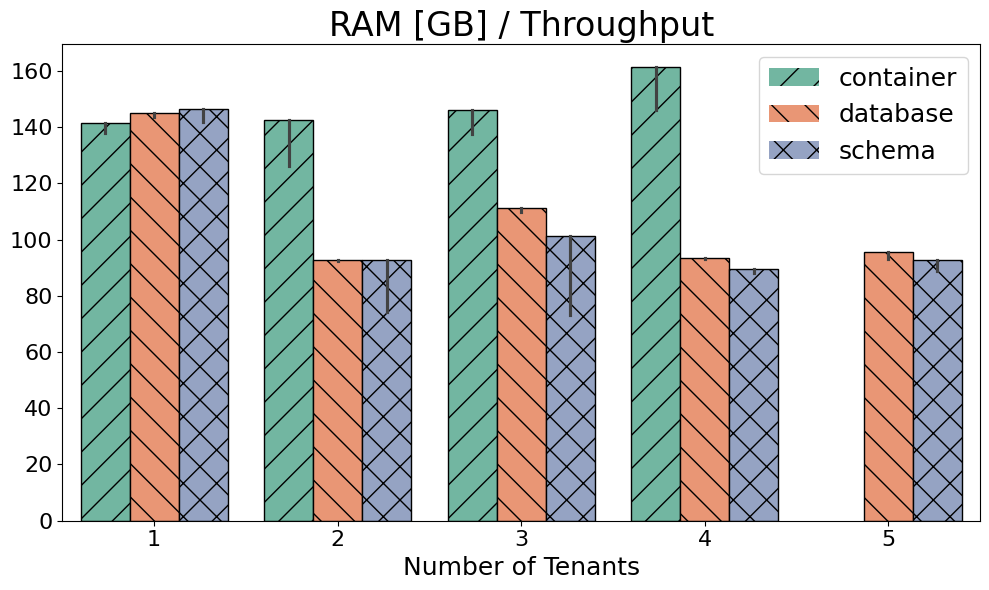

In [89]:
plot_bars(merged_df, y='RAM/Throughput', title='RAM [GB] / Throughput', estimator='max')

In [90]:
client = 1

df_performance_monitoring = get_monitoring_stream_all(codes)
df_performance_monitoring["client"] = df_performance_monitoring["client"].astype(int)
df_performance_monitoring = df_performance_monitoring[df_performance_monitoring['client'] == client]
df_performance = get_performance_all(codes)
df_performance["client"] = df_performance["client"].astype(int)
df_performance = df_performance[df_performance['client'] == client]
merged_df = pd.merge(df_performance, df_performance_monitoring, on=['type', 'num_tenants', 'client'], how='inner')
merged_df['RAM/Throughput'] = merged_df['Max RAM [Gb]'] / merged_df['Throughput@Size'] * 1000.
merged_df['CPUs/Throughput'] = merged_df['CPU [CPUs]'] / merged_df['Throughput@Size'] / 3600. * 1000.

merged_df

,client,Throughput@Size,time [s],num_of_queries,SF,count,Power@Size [~Q/h],type,num_tenants,CPU [CPUs],Max RAM [Gb],Max RAM Cached [Gb],Max CPU,RAM/Throughput,CPUs/Throughput
0,1,807.75,1961,22,10.0,2,6368.099072,container,2,21122.16,102.01,133.83,15.92,126.289075,7.263716
1,1,793.98,1995,22,10.0,2,6172.264282,database,2,21627.18,73.43,104.86,14.84,92.483438,7.566374
2,1,792.40,1999,22,10.0,2,6204.870707,schema,2,21782.59,58.97,90.77,14.08,74.419485,7.635941
3,1,416.84,1900,22,10.0,1,6453.282885,container,1,10249.41,57.44,73.35,7.95,137.798676,6.830099
4,1,400.00,1980,22,10.0,1,6226.076538,database,1,10597.67,57.45,73.36,7.98,143.625000,7.359493
5,1,404.70,1957,22,10.0,1,6274.472477,schema,1,10827.06,57.44,73.35,7.98,141.932296,7.431472
6,1,1196.98,1985,22,10.0,3,6320.524073,container,3,32000.65,164.70,208.89,23.93,137.596284,7.426247
7,1,1159.02,2050,22,10.0,3,6038.466204,database,3,33336.32,127.23,174.93,21.61,109.773774,7.989585
8,1,1161.29,2046,22,10.0,3,6058.351172,schema,3,33096.24,85.15,131.77,20.91,73.323631,7.916541
9,1,1515.79,2090,22,10.0,4,5935.299218,schema,4,44905.47,135.77,198.45,28.60,89.570455,8.229202


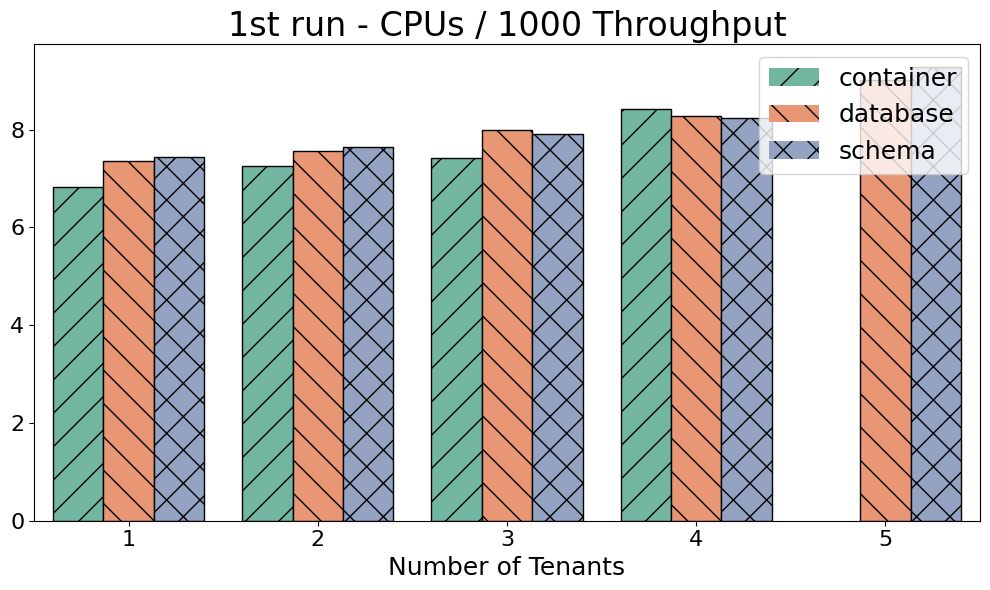

In [91]:
plot_bars(merged_df, y='CPUs/Throughput', title='1st run - CPUs / 1000 Throughput', estimator='max')

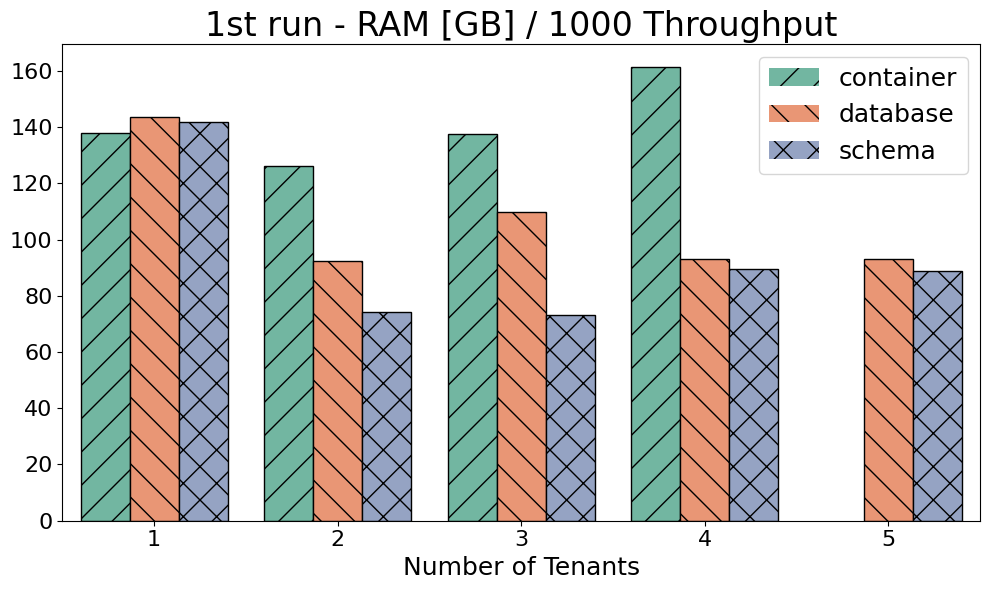

In [92]:
plot_bars(merged_df, y='RAM/Throughput', title='1st run - RAM [GB] / 1000 Throughput', estimator='max')

In [93]:
client = 2

df_performance_monitoring = get_monitoring_stream_all(codes)
df_performance_monitoring["client"] = df_performance_monitoring["client"].astype(int)
df_performance_monitoring = df_performance_monitoring[df_performance_monitoring['client'] == client]
df_performance = get_performance_all(codes)
df_performance["client"] = df_performance["client"].astype(int)
df_performance = df_performance[df_performance['client'] == client]
merged_df = pd.merge(df_performance, df_performance_monitoring, on=['type', 'num_tenants', 'client'], how='inner')
merged_df['RAM/Throughput'] = merged_df['Max RAM [Gb]'] / merged_df['Throughput@Size'] * 1000.
merged_df['CPUs/Throughput'] = merged_df['CPU [CPUs]'] / merged_df['Throughput@Size'] / 3600. * 1000.

merged_df

,client,Throughput@Size,time [s],num_of_queries,SF,count,Power@Size [~Q/h],type,num_tenants,CPU [CPUs],Max RAM [Gb],Max RAM Cached [Gb],Max CPU,RAM/Throughput,CPUs/Throughput
0,2,818.60,1935,22,10.0,2,6392.959585,container,2,20536.07,116.66,148.48,15.94,142.511605,6.968561
1,2,798.79,1983,22,10.0,2,6205.299555,database,2,21213.02,73.99,105.29,15.30,92.627599,7.376789
2,2,793.19,1997,22,10.0,2,6193.703735,schema,2,21532.46,73.67,105.46,14.96,92.878125,7.540739
3,2,412.29,1921,22,10.0,1,6399.072262,container,1,10563.69,58.33,74.24,7.96,141.478086,7.117219
4,2,402.64,1967,22,10.0,1,6270.759668,database,1,10686.47,58.34,74.26,7.96,144.893702,7.372501
5,2,398.19,1989,22,10.0,1,6236.568739,schema,1,10890.06,58.33,74.24,7.95,146.487858,7.596918
6,2,1188.00,2000,22,10.0,3,6266.801892,container,3,32211.67,173.75,219.02,23.47,146.254209,7.531722
7,2,1156.20,2055,22,10.0,3,6033.349474,database,3,33425.27,128.66,176.04,21.15,111.278326,8.030442
8,2,1159.02,2050,22,10.0,3,6073.307784,schema,3,33183.98,117.26,163.36,21.21,101.171680,7.953074
9,2,1502.13,2109,22,10.0,4,5907.812948,schema,4,45464.51,132.11,195.24,28.90,87.948447,8.407415


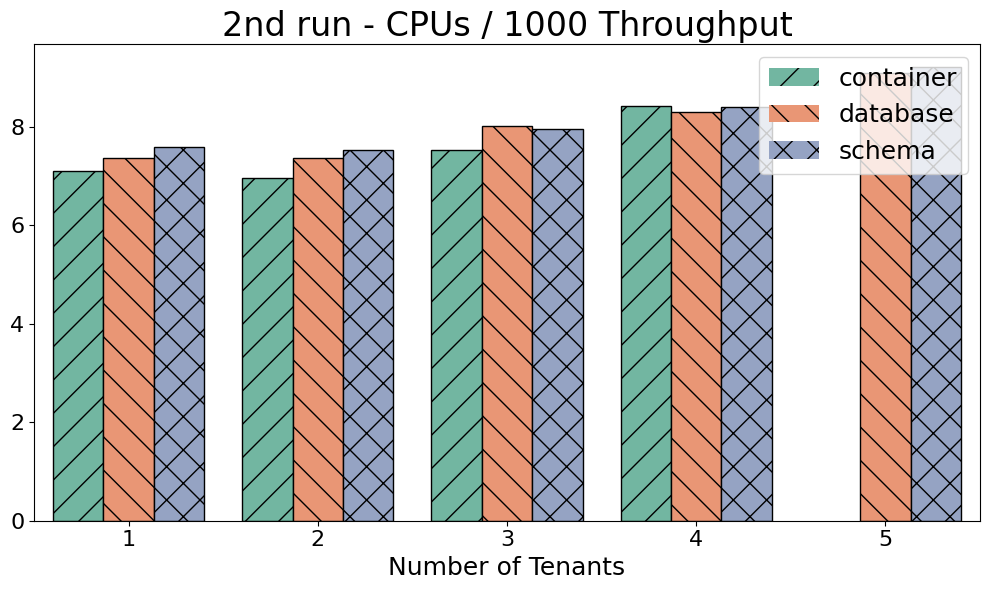

In [94]:
plot_bars(merged_df, y='CPUs/Throughput', title='2nd run - CPUs / 1000 Throughput', estimator='max')

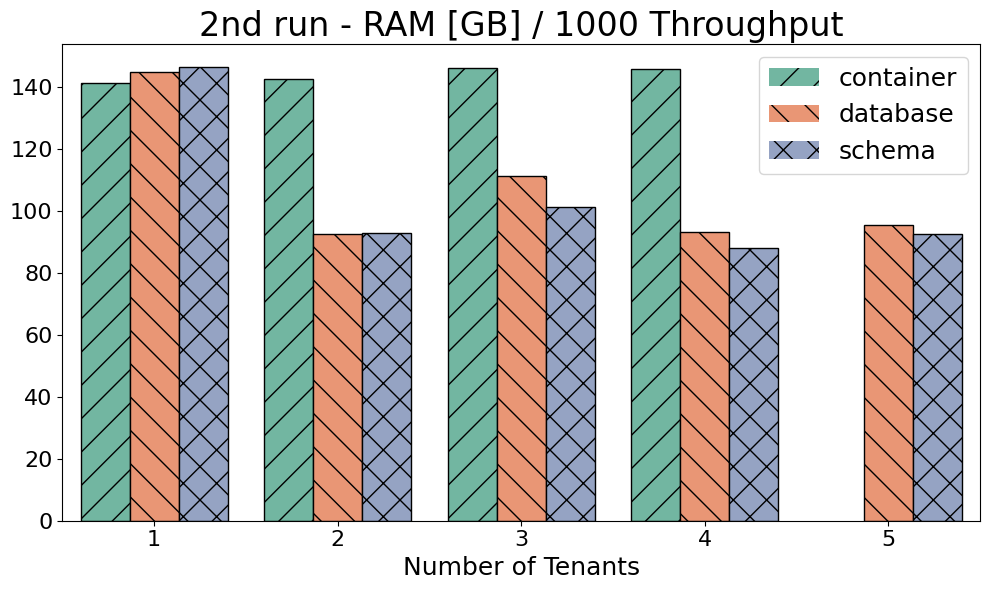

In [95]:
plot_bars(merged_df, y='RAM/Throughput', title='2nd run - RAM [GB] / 1000 Throughput', estimator='max')